<a href="https://www.kaggle.com/code/lonnieqin/tps-22-03-with-lstm?scriptVersionId=115551421" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# TPS-22-03 with LSTM

In [1]:
import numpy as np 
import tensorflow as tf
import pandas as pd
import math
from tensorflow import keras

## Common Parameters

In [2]:
sequence_length = 32
batch_size = 1024
categorical_columns = ["x", "y", "direction", "hour", "month", "dayofweek"]
sequence_categorical_columns = ["x", "y", "direction"]
is_training = True

## Import dataset

In [3]:
train = pd.read_csv("../input/tabular-playground-series-mar-2022/train.csv")
direction_map = dict()
for i, direction in enumerate(train.direction.unique()):
    direction_map[direction] = i

## Feature Engineering

In [4]:
 def feature_engineering(data):
    data["key"] = data["x"].map(lambda item: str(item)) + "_" + data["y"].map(lambda item: str(item)) + "_" + data["direction"]
    data["direction"] = data["direction"].map(lambda item: direction_map[item])
    data['time'] = pd.to_datetime(data['time'])
    data['month'] = data['time'].dt.month
    data['dayofweek'] = data['time'].dt.dayofweek
    data['hour'] = data['time'].dt.hour
    data = data.drop(['time'], axis=1)
    return data

In [5]:
train = feature_engineering(train)

In [6]:
train.head(30)

,row_id,x,y,direction,congestion,key,month,dayofweek,hour
0,0,0,0,0,70,0_0_EB,4,0,0
1,1,0,0,1,49,0_0_NB,4,0,0
2,2,0,0,2,24,0_0_SB,4,0,0
3,3,0,1,0,18,0_1_EB,4,0,0
4,4,0,1,1,60,0_1_NB,4,0,0
5,5,0,1,2,58,0_1_SB,4,0,0
6,6,0,1,3,26,0_1_WB,4,0,0
7,7,0,2,0,31,0_2_EB,4,0,0
8,8,0,2,1,49,0_2_NB,4,0,0
9,9,0,2,2,46,0_2_SB,4,0,0


## EDA

When groupping the dataset by x, y and direction, each dataset contains 13059 records.

In [7]:
set(train["key"].value_counts())

{13059}

Target value is very volatile even for latest data.

<AxesSubplot:>

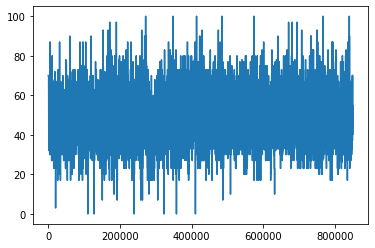

In [8]:
train[train.key=="0_0_EB"].congestion.plot()

<AxesSubplot:>

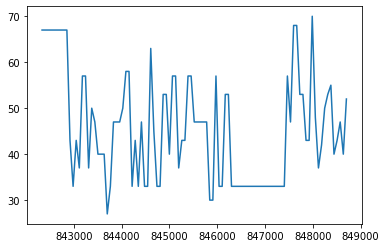

In [9]:
train[train.key=="0_0_EB"].congestion[-100:-1].plot()

## Make Tensorflow Time Series Dataset

In [10]:
def preprocess(window):
    return (
        window[:-1, 0], 
        window[:-1, 1], 
        window[:-1, 2],  
        window[:-1, 3], 
        window[-1, 0],
        window[-1, 1],
        window[-1, 2],
        window[-1, 3],
        window[-1, 4],
        window[-1, 5]
    ), window[-1:, -1]
def make_dataset(df, sequence_length=32, mode="train"):
    dataset = tf.data.Dataset.from_tensor_slices((df[categorical_columns + ["congestion"]]))
    dataset = dataset.window(sequence_length + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(sequence_length + 1))
    dataset = dataset.map(preprocess)
    if mode == "train":
        dataset = dataset.shuffle(buffer_size=batch_size)
    dataset = dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return dataset

In [11]:
split_fraction = 0.9
split_index = int(len(train) * split_fraction)
train_data = train[0:split_index]
val_data = train[split_index:]
train_data.shape, val_data.shape
train_ds = make_dataset(train_data)
valid_ds = make_dataset(val_data, mode="valid")

2023-01-05 09:26:40.878777: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
for item in train_ds.take(1):
    print(item)

2023-01-05 09:26:41.199183: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


((<tf.Tensor: shape=(1024, 32), dtype=int64, numpy=
array([[0, 0, 0, ..., 2, 2, 2],
       [2, 2, 2, ..., 1, 1, 1],
       [2, 2, 0, ..., 1, 1, 1],
       ...,
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [1, 1, 1, ..., 2, 2, 2]])>, <tf.Tensor: shape=(1024, 32), dtype=int64, numpy=
array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 1, 1, 2],
       [3, 3, 0, ..., 2, 2, 2],
       ...,
       [1, 1, 1, ..., 2, 2, 3],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 1, 1, ..., 2, 2, 2]])>, <tf.Tensor: shape=(1024, 32), dtype=int64, numpy=
array([[0, 1, 4, ..., 1, 2, 3],
       [4, 2, 5, ..., 2, 3, 0],
       [5, 3, 0, ..., 0, 1, 4],
       ...,
       [4, 6, 2, ..., 2, 3, 0],
       [0, 1, 2, ..., 0, 1, 2],
       [3, 0, 1, ..., 0, 1, 4]])>, <tf.Tensor: shape=(1024, 32), dtype=int64, numpy=
array([[3, 3, 3, ..., 3, 3, 3],
       [0, 0, 0, ..., 0, 0, 0],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [3, 3, 3, ..., 4, 4, 4],
     

2023-01-05 09:26:41.503685: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Model Development

### Create Lookup layers

In [13]:
%%time
lookupLayersMap = dict()
for column in categorical_columns:
    unique_values = list(train[column].unique())
    lookupLayersMap[column] = tf.keras.layers.IntegerLookup(vocabulary=unique_values)

CPU times: user 540 ms, sys: 86.6 ms, total: 627 ms
Wall time: 858 ms


In [14]:
def get_model():
    sequence_inputs = []
    sequence_vectors = []
    dense_inputs = []
    dense_vectors = []
    for column in sequence_categorical_columns:
        sequence_input = keras.Input(shape=(sequence_length, 1), name=f"{column}_sequnce_input")
        lookup = lookupLayersMap[column]
        vocab_size = len(lookup.get_vocabulary())
        embed_dimension = max(math.ceil(np.sqrt(vocab_size)), 2)
        sequence_vector = lookup(sequence_input)
        sequence_vector = keras.layers.Embedding(vocab_size, embed_dimension, input_length=sequence_length)(sequence_vector)
        sequence_vector = keras.layers.Reshape((-1, embed_dimension))(sequence_vector)
        sequence_vectors.append(sequence_vector)
        sequence_inputs.append(sequence_input)
    target_sequence_input = keras.Input(shape=(sequence_length, 1))
    sequence_inputs.append(target_sequence_input)
    sequence_vectors.append(target_sequence_input)
    sequence_vector = keras.layers.Concatenate(axis=-1)(sequence_vectors)
    sequence_vector = keras.layers.LSTM(128, return_sequences=True)(sequence_vector)
    sequence_vector = keras.layers.LSTM(64, return_sequences=False)(sequence_vector)
    sequence_vector = keras.layers.Dense(128, activation="relu")(sequence_vector)
    sequence_vector = keras.layers.Dense(128, activation="relu")(sequence_vector)
    sequence_vector = keras.layers.Dense(128, activation="relu")(sequence_vector)
    sequence_vector = keras.layers.Dense(128, activation="relu")(sequence_vector)

    for column in categorical_columns:
        dense_input = keras.Input(shape=(1, ), name=f"{column}_dense_input")
        lookup = lookupLayersMap[column]
        vocab_size = len(lookup.get_vocabulary())
        embed_dimension = max(math.ceil(np.sqrt(vocab_size)), 2)
        dense_vector = lookup(dense_input)
        dense_vector = keras.layers.Embedding(vocab_size, embed_dimension, input_length=1)(dense_vector)
        dense_vector = keras.layers.Reshape((-1,))(dense_vector)
        dense_vectors.append(dense_vector)
        dense_inputs.append(dense_input)
        
    dense_vector = keras.layers.Concatenate(axis=-1)(dense_vectors)
    dense_vector = keras.layers.Dense(128, activation="relu")(dense_vector)
    dense_vector = keras.layers.Dense(128, activation="relu")(dense_vector)
    dense_vector = keras.layers.Dense(128, activation="relu")(dense_vector)
    dense_vector = keras.layers.Dense(128, activation="relu")(dense_vector)

    vector = keras.layers.Concatenate(axis=-1)([sequence_vector, dense_vector])
    vector = keras.layers.Dense(32, activation="relu")(vector)
    output = keras.layers.Dense(1)(vector)
    model = keras.Model(inputs=sequence_inputs + dense_inputs, outputs=output)
    model.compile(loss="huber_loss", optimizer="adam", metrics=["mae"])
    return model

## Create Model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_sequnce_input (InputLayer)    [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
y_sequnce_input (InputLayer)    [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
direction_sequnce_input (InputL [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  multiple             0           x_sequnce_input[0][0]            
                                                                 x_dense_input[0][0]          

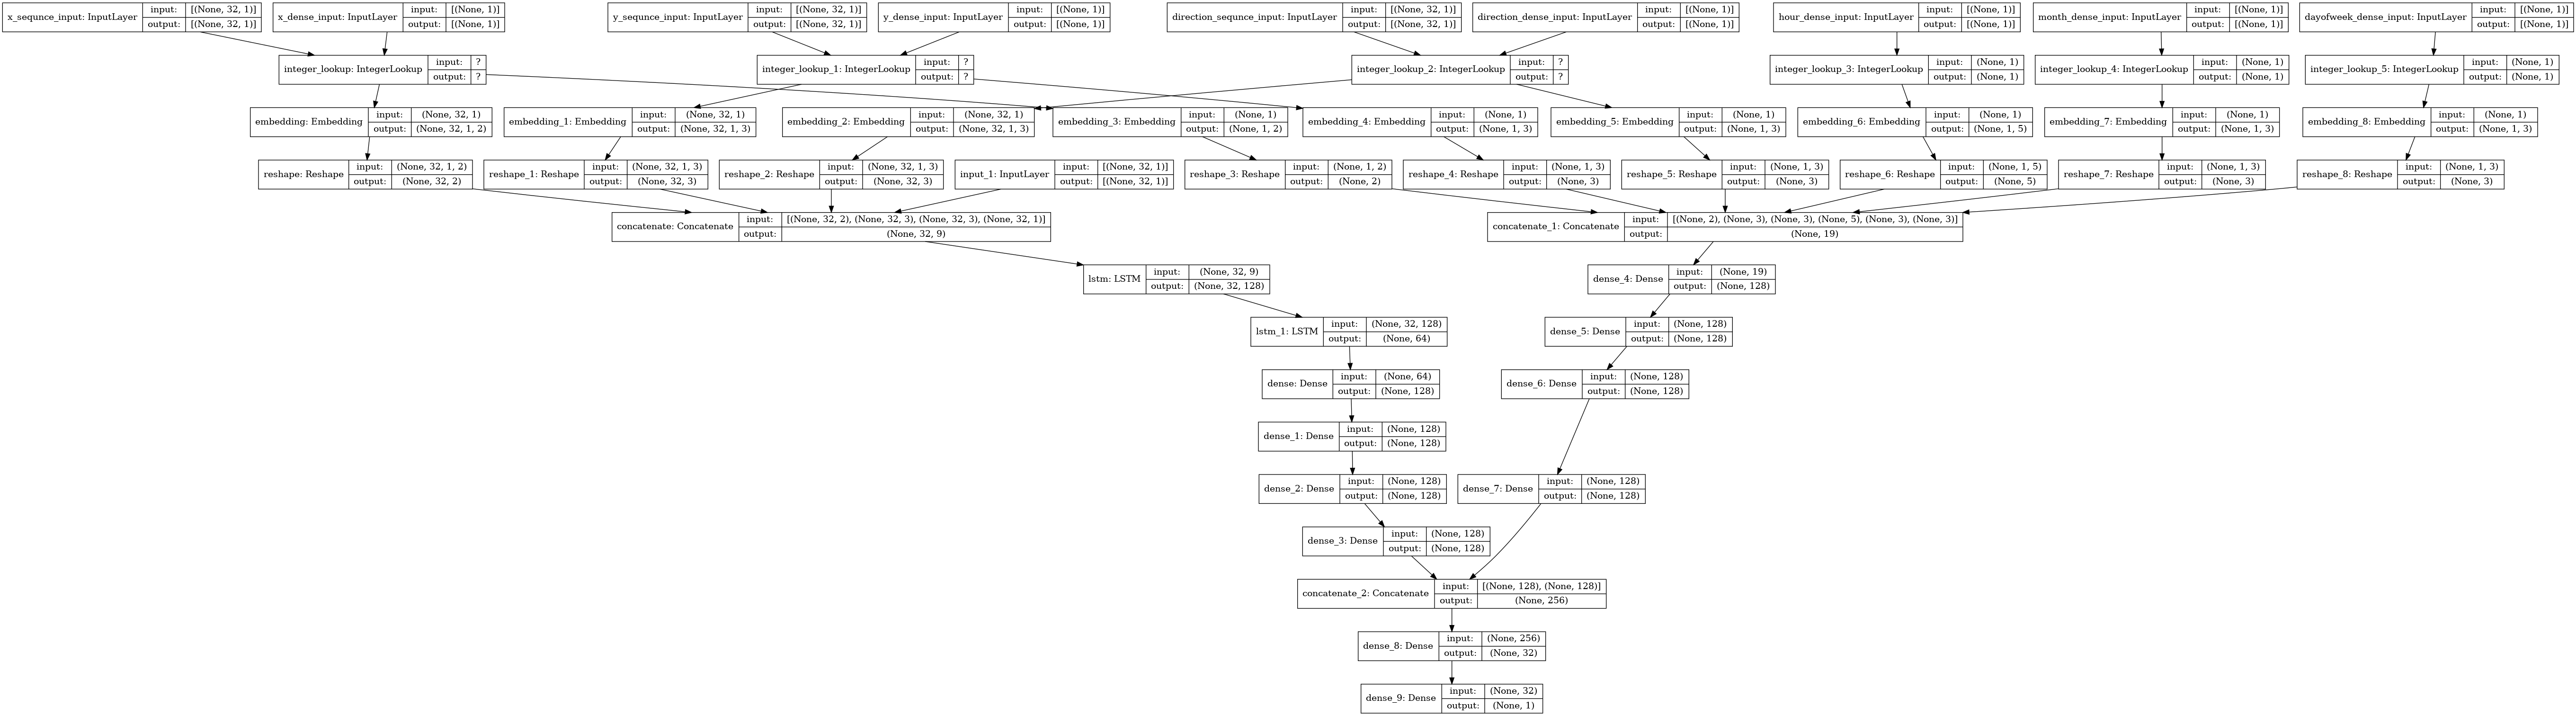

In [15]:
model = get_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

## Model Training

In [16]:
cp = keras.callbacks.ModelCheckpoint("model.tf", monitor="val_mae", save_best_only=True, save_weights_only=True)
es = keras.callbacks.EarlyStopping(patience=10)
if is_training:
    model.fit(train_ds, epochs=50, validation_data=valid_ds, callbacks=[es, cp])
    model.load_weights("model.tf")
else:
    model.load_weights(f"../input/tps2203-lstm-output/model.tf")

Epoch 1/50
747/747 [==============================] - 339s 448ms/step - loss: 10.9235 - mae: 11.4125 - val_loss: 7.7934 - val_mae: 8.2788
Epoch 2/50
747/747 [==============================] - 281s 376ms/step - loss: 7.6613 - mae: 8.1452 - val_loss: 7.0622 - val_mae: 7.5421
Epoch 3/50
747/747 [==============================] - 285s 381ms/step - loss: 6.9224 - mae: 7.4037 - val_loss: 6.7064 - val_mae: 7.1862
Epoch 4/50
747/747 [==============================] - 291s 390ms/step - loss: 6.9452 - mae: 7.4265 - val_loss: 7.9140 - val_mae: 8.3979
Epoch 5/50
747/747 [==============================] - 288s 385ms/step - loss: 8.6202 - mae: 9.1050 - val_loss: 18.6859 - val_mae: 19.1820
Epoch 6/50
747/747 [==============================] - 290s 388ms/step - loss: 9.6147 - mae: 10.1029 - val_loss: 7.9645 - val_mae: 8.4482
Epoch 7/50
747/747 [==============================] - 289s 387ms/step - loss: 7.0298 - mae: 7.5119 - val_loss: 7.6041 - val_mae: 8.0902
Epoch 8/50
747/747 [=======================

## Submission

In [17]:
def make_test_dataset(df, congestions, sequence_length=32):
    data = df.copy()
    items = congestions[-sequence_length:len(congestions)] + [0]
    data["congestion"] = items
    dataset = tf.data.Dataset.from_tensor_slices((data))
    dataset = dataset.window(sequence_length + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(sequence_length + 1))
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(1)
    return dataset

In [18]:
%%time
import time
begin = time.time()
test = pd.read_csv("../input/tabular-playground-series-mar-2022/test.csv")
test = feature_engineering(test)
submission = pd.read_csv("../input/tabular-playground-series-mar-2022/sample_submission.csv")
first_batch = train.iloc[-sequence_length-1:-1]
df = pd.concat([first_batch[categorical_columns], test[categorical_columns]])
congestions = list(first_batch["congestion"])
for i in range(len(test)):
    ds = make_test_dataset(df.iloc[i: i+sequence_length+1], congestions, sequence_length=sequence_length)
    congestion = model.predict(ds)[0][0]
    congestions.append(congestion)
    if (i + 1) % 100 == 0:
        elaspsed_time = time.time() - begin
        estimated_time = elaspsed_time / (i + 1) * len(test)
        eta = estimated_time - elaspsed_time
        print(f"ETA: %.2f"%(eta))
submission["congestion"] = np.round(congestions[sequence_length:])
submission.to_csv("submission.csv", index=False)

ETA: 345.13
ETA: 311.93
ETA: 293.26
ETA: 275.48
ETA: 259.97
ETA: 244.40
ETA: 229.49
ETA: 214.27
ETA: 200.51
ETA: 185.79
ETA: 171.09
ETA: 156.78
ETA: 142.46
ETA: 128.74
ETA: 114.71
ETA: 101.13
ETA: 87.31
ETA: 73.53
ETA: 59.84
ETA: 46.24
ETA: 32.64
ETA: 19.02
ETA: 5.44
CPU times: user 5min 23s, sys: 11.8 s, total: 5min 35s
Wall time: 5min 18s
